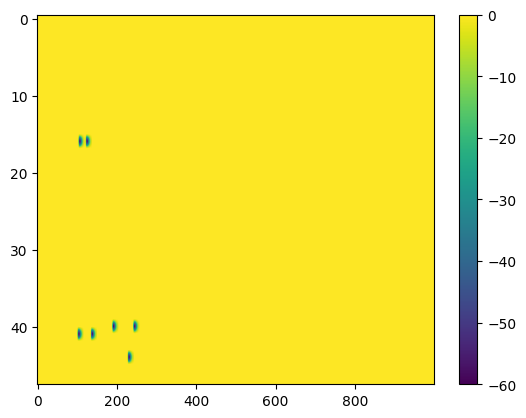

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch.nn.functional as F
import torch
from tqdm import trange
from math import ceil, floor, exp, sqrt, sin

waveform_LUT = np.load(
    "/sdf/data/neutrino/2x2/light_lut/light_wvfm_temp/light_wvfm_LUT_dEdx2_ix0_iy0.npy"
)

waveform_0 = waveform_LUT[32, :, :]
plt.imshow(waveform_0, aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

In [130]:
# Code to sample from timing distribution
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from gplib import TPhotonLib
from photonlib.meta import VoxelMeta

with h5py.File("data/lightLUT_Mod0_06052024.h5", "r") as f:
    d_ = f["arr"][:]
d_["time_dist"].shape
X, Y, Z, C, T = d_["time_dist"].shape
waveform_dist = torch.tensor(d_["time_dist"].astype(np.float32))
waveform_dist_norm = F.normalize(waveform_dist.reshape(-1, C * T), p=1, dim=-1).reshape(
    X, Y, Z, C, T
)
waveform_dist_norm_center = waveform_dist_norm[32, 1, 16].numpy()

# Compute cumulative distribution function (CDF)
cdf = np.cumsum(waveform_dist_norm_center.ravel())
cdf /= cdf[-1]  # Normalize CDF


def sample_timing_distribution(num_photon):
    u = np.random.rand(num_photon)
    sampled_idx = np.searchsorted(cdf, u)

    output = np.zeros_like(waveform_dist_norm_center)
    indexes, counts = np.unique(sampled_idx, return_counts=True)
    output.ravel()[indexes] = counts

    output = np.pad(
        output,
        ((0, 0), (2560, 16000 - output.shape[1] - 2560)),
        mode="constant",
    )
    return output

In [16]:
@nb.njit
def get_triggers(signal):
    """
    Identifies each simulated ticks that would initiate a trigger taking into account the ADC digitization window

    Returns:
        tuple: array of tick indices at each trigger (shape `(ntrigs,)`) and array of op channel index (shape `(ntrigs, ndet_module)`)
    """

    op_channel_idx = np.arange(48)
    trigger_idx_list = [np.asarray(0)]
    op_channel_idx_list = [np.asarray(op_channel_idx)]
    trigger_type_list = [np.asarray(1)]

    if len(trigger_idx_list):
        return (
            np.array(trigger_idx_list),
            np.array(op_channel_idx_list),
            np.array(trigger_type_list),
        )
    return (
        np.empty((0,), dtype=int),
        np.empty((0, len(op_channel_idx)), dtype=int),
        np.empty((0,), dtype=int),
    )


def digitize_signal(
    signal,
    signal_op_channel_idx,
    trigger_idx,
    trigger_op_channel_idx,
    signal_true_track_id,
    signal_true_photons,
    digit_signal,
    digit_signal_true_track_id,
    digit_signal_true_photons,
):
    """
    Interpolate signal to the appropriate sampling frequency

    Args:
        signal(array): shape `(ndet, nticks)`, simulated signal on each channel
        signal_op_channel_idx(array): shape `(ndet,)`, optical channel index for each simulated signal
        trigger_idx(array): shape `(ntrigs,)`, tick index for each trigger
        trigger_op_channel_idx(array): shape `(ntrigs, ndet_module)`, optical channel index for each trigger
        digit_signal(array): output array, shape `(ntrigs, ndet_module, nsamples)`, digitized signal
    """

    for itrig in range(digit_signal.shape[0]):
        for idet_module in range(digit_signal.shape[1]):
            for isample in range(digit_signal.shape[2]):
                sample_tick = (
                    isample * light.LIGHT_DIGIT_SAMPLE_SPACING / light.LIGHT_TICK_SIZE
                )
                idet = trigger_op_channel_idx[itrig, idet_module]
                idet_signal = 0
                for idet_signal in range(signal.shape[0]):
                    if idet == signal_op_channel_idx[idet_signal]:
                        break
                if idet_signal == signal.shape[0]:
                    return
                digit_signal[itrig, idet_module, isample] = interp(
                    sample_tick, signal[idet_signal], 0, 0
                )


def sim_triggers(
    signal,
    signal_op_channel_idx,
    signal_true_track_id,
    signal_true_photons,
    trigger_idx,
    op_channel_idx,
    digit_samples,
    light_det_noise,
):
    """
    Generates digitized waveforms at specified simulation tick indices

    Args:
        bpg(tuple): blocks per grid used to generate digitized waveforms, `len(bpg) == 3`, `prod(bpg) * prod(tpb) >= digit_samples.size`
        tpb(tuple): threads per grid used to generate digitized waveforms, `len(bpg) == 3`, `bpg[i] * tpb[i] >= digit_samples.shape[i]`
        signal(array): shape `(ndet, nticks)`, simulated signal on each channel
        signal_op_channel_idx(array): shape `(ndet,)`, optical channel index for each simulated signal
        signal_true_track_id(array): shape `(ndet, nticks, ntruth)`, true segments associated with each tick
        signal_true_photons(array): shape `(ndet, nticks, ntruth)`, true photons associated with each tick from each track
        trigger_idx(array): shape `(ntrigs,)`, tick index for each trigger to digitize
        op_channel_idx(array): shape `(ntrigs, ndet_module)`, optical channel indices for each trigger
        digit_samples(int): number of digitizations per waveform
        light_det_noise(array): shape `(ndet, nnoise_bins)`, noise spectrum for each channel (only used if waveforms extend past simulated signal)

    Returns:
        array: shape `(ntrigs, ndet_module, digit_samples)`, digitized waveform on each channel for each trigger
    """
    digit_signal = np.zeros(
        (trigger_idx.shape[0], op_channel_idx.shape[-1], digit_samples), dtype="f8"
    )
    digit_signal_true_track_id = None
    digit_signal_true_photons = None

    # exit if no triggers
    if digit_signal.shape[0] == 0:
        return digit_signal

    padded_trigger_idx = trigger_idx.copy()

    digitize_signal(
        signal,
        signal_op_channel_idx,
        padded_trigger_idx,
        op_channel_idx,
        signal_true_track_id,
        signal_true_photons,
        digit_signal,
        digit_signal_true_track_id,
        digit_signal_true_photons,
    )

    # truncate to correct number of bits
    digit_signal = np.round(digit_signal / 2 ** (16 - light.LIGHT_NBIT)) * 2 ** (
        16 - light.LIGHT_NBIT
    )

    return digit_signal

In [138]:
import torch
import torch.nn as nn
from larndsim.const import light
import math


class LightSimulation(nn.Module):
    def __init__(self, ndet=48, nticks=100):
        super().__init__()
        self.ndet = ndet
        self.nticks = nticks

        # Differentiable parameters
        self.singlet_fraction = nn.Parameter(
            torch.tensor(light.SINGLET_FRACTION)
        )  # Example initial value
        self.tau_s = nn.Parameter(torch.tensor(light.TAU_S))  # in ns
        self.tau_t = nn.Parameter(torch.tensor(light.TAU_T))  # in ns
        self.light_oscillation_period = nn.Parameter(
            torch.tensor(light.LIGHT_OSCILLATION_PERIOD)
        )  # in ns
        self.light_response_time = nn.Parameter(
            torch.tensor(light.LIGHT_RESPONSE_TIME)
        )  # in ns
        self.light_gain = nn.Parameter(-torch.ones(ndet))  # One gain per detector

        # Constants
        self.light_tick_size = light.LIGHT_TICK_SIZE
        self.light_window = light.LIGHT_WINDOW

    def scintillation_model(self, time_tick):
        """
        Calculates the fraction of scintillation photons emitted
        during time interval `time_tick` to `time_tick + 1`

        Args:
            time_tick (torch.Tensor): time tick relative to t0
            light (object): object containing light-related constants

        Returns:
            torch.Tensor: fraction of scintillation photons
        """
        p1 = (
            self.singlet_fraction
            * torch.exp(-time_tick * self.light_tick_size / self.tau_s)
            * (1 - torch.exp(-self.light_tick_size / self.tau_s))
        )
        p3 = (
            (1 - self.singlet_fraction)
            * torch.exp(-time_tick * self.light_tick_size / self.tau_t)
            * (1 - torch.exp(-self.light_tick_size / self.tau_t))
        )
        return (p1 + p3) * (time_tick >= 0)

    def calc_scintillation_effect(self, light_sample_inc):
        """
        Applies a smearing effect due to the liquid argon scintillation time profile using
        a two decay component scintillation model.

        Args:
            light_sample_inc (torch.Tensor): shape `(ndet, ntick)`, light incident on each detector
            light (object): object containing light-related constants

        Returns:
            torch.Tensor: shape `(ndet, ntick)`, light incident on each detector after accounting for scintillation time
        """
        device = light_sample_inc.device
        ndet, ntick = light_sample_inc.shape

        conv_ticks = math.ceil(
            (self.light_window[1] - self.light_window[0]) / self.light_tick_size
        )

        # Create the scintillation model kernel
        time_ticks = torch.arange(conv_ticks, device=device)
        kernel = self.scintillation_model(time_ticks).flip(0)

        # Pad the input tensor
        padded_input = torch.nn.functional.pad(light_sample_inc, (conv_ticks - 1, 0))

        # Reshape for grouped convolution
        padded_input = padded_input.view(1, ndet, -1)

        # Create a separate kernel for each detector
        kernel = kernel.repeat(ndet, 1).view(ndet, 1, -1)

        # Perform the convolution
        light_sample_inc_scint = torch.nn.functional.conv1d(
            padded_input, kernel, groups=ndet
        )

        # Trim the result to match the input shape
        light_sample_inc_scint = light_sample_inc_scint.view(ndet, -1)[:, :ntick]

        return light_sample_inc_scint

    def sipm_response_model(self, time_tick):
        """
        Calculates the SiPM response from a PE at `time_tick` relative to the PE time

        Args:
            time_tick (torch.Tensor): time tick relative to t0
            light (object): object containing light-related constants

        Returns:
            torch.Tensor: response
        """
        t = time_tick * self.light_tick_size
        impulse = (
            (t >= 0)
            * torch.exp(-t / self.light_response_time)
            * torch.sin(t / self.light_oscillation_period)
        )
        # normalize to 1
        impulse /= self.light_oscillation_period * self.light_response_time**2
        impulse *= self.light_oscillation_period**2 + self.light_response_time**2
        return impulse * self.light_tick_size

    def calc_light_detector_response(self, light_sample_inc):
        """
        Simulates the SiPM response and digit

        Args:
            light_sample_inc (torch.Tensor): shape `(ndet, ntick)`, PE produced on each SiPM at each time tick
            light (object): object containing light-related constants

        Returns:
            torch.Tensor: shape `(ndet, ntick)`, ADC value at each time tick
        """
        device = light_sample_inc.device
        ndet, ntick = light_sample_inc.shape

        conv_ticks = math.ceil(
            (self.light_window[1] - self.light_window[0]) / self.light_tick_size
        )

        # Create the SiPM response model kernel
        time_ticks = torch.arange(conv_ticks, device=device)
        kernel = self.sipm_response_model(time_ticks).flip(0)

        # Pad the input tensor
        padded_input = torch.nn.functional.pad(light_sample_inc, (conv_ticks - 1, 0))

        # Reshape for grouped convolution
        padded_input = padded_input.view(1, ndet, -1)

        # Create a separate kernel for each detector
        kernel = kernel.repeat(ndet, 1).view(ndet, 1, -1)

        # Perform the convolution
        light_response = torch.nn.functional.conv1d(padded_input, kernel, groups=ndet)

        # Trim the result to match the input shape
        light_response = light_response.view(ndet, -1)[:, :ntick]

        # Apply the gain
        light_response *= self.light_gain.view(-1, 1)

        return light_response

    def forward(self, timing_dist, digitize=False, return_intermediates=False):
        scint_response = self.calc_scintillation_effect(timing_dist)
        light_detector_response = self.calc_light_detector_response(scint_response)

        downsample = torch.zeros(light_detector_response.shape[0], 1000)
        ntick = 1000
        ns_per_tick = 16
        for tick in range(ntick):
            downsample[:, tick] = light_detector_response[
                :, tick * ns_per_tick : (tick + 1) * ns_per_tick
            ].sum(dim=1)

        if return_intermediates:
            return timing_dist, scint_response, light_detector_response, downsample

        if digitize:
            downsample = torch.round(light_detector_response / 2 ** (16 - 12)) * 2 ** (
                16 - 12
            )
        return downsample

In [139]:
sim = LightSimulation()


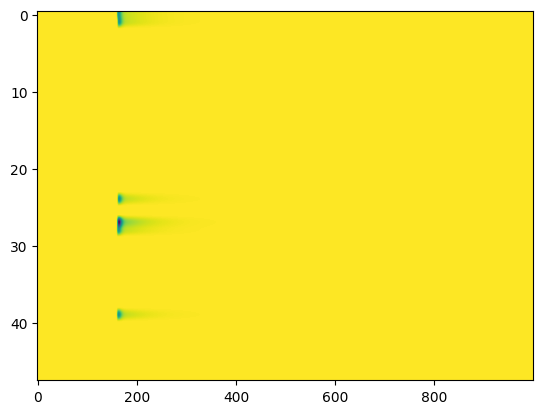

In [140]:
timing_dist = sample_timing_distribution(7)
plt.imshow(
    sim(torch.tensor(timing_dist), digitize=False).detach().numpy(), aspect="auto"
)